In [1]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [2]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from matplotlib import pyplot as plt
from tqdm import trange
from torch.distributions.normal import Normal
from torch.distributions.laplace import Laplace
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader

# ResNet20

Implementation taken [from](https://github.com/JayPatwardhan/ResNet-PyTorch/blob/master/ResNet/ResNet.py).

In [3]:
class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Bottleneck, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
        self.batch_norm3 = nn.BatchNorm2d(out_channels*self.expansion)
        
        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()
        
    def forward(self, x):
        identity = x.clone()
        x = self.relu(self.batch_norm1(self.conv1(x)))
        
        x = self.relu(self.batch_norm2(self.conv2(x)))
        
        x = self.conv3(x)
        x = self.batch_norm3(x)
        
        #downsample if needed
        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
        #add identity
        x+=identity
        x=self.relu(x)
        
        return x

In [4]:
class Block(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Block, self).__init__()
       

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()

    def forward(self, x):
        identity = x.clone()

        x = self.relu(self.batch_norm2(self.conv1(x)))
        x = self.batch_norm2(self.conv2(x))

        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
        print(x.shape)
        print(identity.shape)
        x += identity
        x = self.relu(x)
        return x

In [5]:
class ResNet(nn.Module):
    def __init__(self, ResBlock, layer_list, num_classes, num_channels=3):
        super(ResNet, self).__init__()
        self.in_channels = 64
        
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size = 3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(ResBlock, layer_list[0], planes=64)
        self.layer2 = self._make_layer(ResBlock, layer_list[1], planes=128, stride=2)
        self.layer3 = self._make_layer(ResBlock, layer_list[2], planes=256, stride=2)
        self.layer4 = self._make_layer(ResBlock, layer_list[3], planes=512, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*ResBlock.expansion, num_classes)
        
    def forward(self, x):
        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.max_pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        
        return x
        
    def _make_layer(self, ResBlock, blocks, planes, stride=1):
        ii_downsample = None
        layers = []
        
        if stride != 1 or self.in_channels != planes*ResBlock.expansion:
            ii_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, planes*ResBlock.expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes*ResBlock.expansion)
            )
            
        layers.append(ResBlock(self.in_channels, planes, i_downsample=ii_downsample, stride=stride))
        self.in_channels = planes*ResBlock.expansion
        
        for i in range(blocks-1):
            layers.append(ResBlock(self.in_channels, planes))
            
        return nn.Sequential(*layers)

In [6]:
def ResNet20(num_classes, channels=3):
    return ResNet(Bottleneck, [2,2,3,2], num_classes, channels)

In [7]:
mdl = ResNet20(10)

Code taken [from](https://github.com/kuangliu/pytorch-cifar/blob/master/main.py).

In [10]:
transform_train = torchvision.transforms.Compose([
    torchvision.transforms.RandomCrop(32, padding=4),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [12]:
transform_test = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [19]:
trainset = torchvision.datasets.CIFAR10(
    root='./files/', train=True, download=True, transform=transform_train)
train_dataloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True)

Files already downloaded and verified


In [20]:
testset = torchvision.datasets.CIFAR10(
    root='./files/', train=False, download=True, transform=transform_test)
test_dataloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

Files already downloaded and verified


In [21]:
cross_entropy = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(mdl.parameters(), lr = 1e-3)

In [32]:
n_epochs = 600
device = 'cuda'

In [33]:
writer = SummaryWriter()
mdl = mdl.to(device)
for i in trange(n_epochs):
    total_loss = 0
    for (x, y) in iter(train_dataloader):
        optimizer.zero_grad()
        x = x.to(device)
        y = y.to(device)
        y_pred = mdl(x)
        loss = cross_entropy(y_pred, y)
        total_loss += loss
        loss.backward()
        optimizer.step()
    writer.add_scalar('Loss/train', total_loss / (len(train_dataloader)), i)
    if i % 15 == 0:
        mdl.eval()
        with torch.no_grad():
            total_loss = 0
            accuracy = 0
            for (x, y) in iter(test_dataloader):
                x = x.to(device)
                y = y.to(device)

                y_pred = mdl(x)
                loss_test = cross_entropy(y_pred, y)   
                total_loss += loss_test
                accuracy += (torch.argmax(y_pred, dim = -1) == y).sum() / len(y)
            writer.add_scalar('Loss/test', total_loss / len(test_dataloader), i)
            writer.add_scalar('Accuracy/test', accuracy / len(test_dataloader), i)
        mdl.train()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [3:36:40<00:00, 21.67s/it]


In [34]:
mdl.eval()
with torch.no_grad():
    total_loss = 0
    accuracy = 0
    for (x, y) in iter(test_dataloader):
        x = x.to(device)
        y = y.to(device)

        y_pred = mdl(x)
        loss_test = cross_entropy(y_pred, y)   
        total_loss += loss_test
        accuracy += (torch.argmax(y_pred, dim = -1) == y).sum() / len(y)

In [35]:
accuracy / len(test_dataloader)

tensor(0.7700, device='cuda:0')

In [36]:
torch.save(mdl.state_dict(), './models/cifar10_resnet20')

In [37]:
parameters = []
for param in mdl.parameters():
    parameters += param.view(-1, np.prod(param.shape)).detach().cpu().squeeze().tolist()

# or
#for name, param in model.named_parameters():

Text(0.5, 1.0, "Histogram with 'auto' bins")

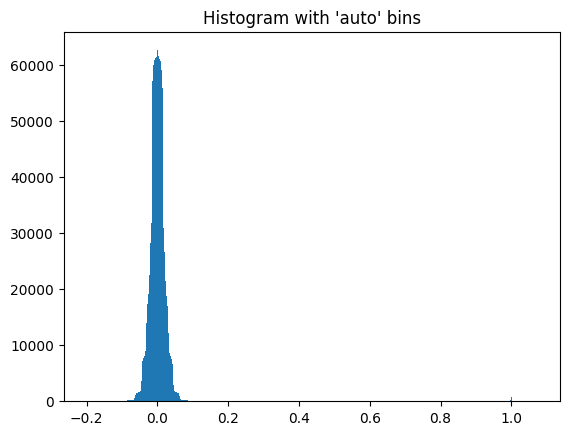

In [38]:
import matplotlib.pyplot as plt

_ = plt.hist(parameters, bins='auto')  # arguments are passed to np.histogram

plt.title("Histogram with 'auto' bins")